# Exercise 18.1
## Generation of fashion images using Generative Adversarial Networks

Let us start to learn how to implement (Generative Adversarial Networks) GAN, as introduced by [Goodfellow et al.](https://arxiv.org/abs/1406.2661) in Keras, to gain more insights into the training procedure. 

As a simple example, we will use GAN to generate small greyscale images.
We will use the fashion MNIST data for training the GAN.

 1. Pre-train the discriminator and evaluate the test accuracy.
 2. Set up the main loop for training the adversarial framework. Use uniform distributed noise as prior distribution for the generator.
 3. Generate some images after each training epoch. Plot the training losses for the generator and discriminator and generated images.

Training GANs can be computationally demanding, thus, we recommend to use a GPU for this task.

### Software
First we have to import our software.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
layers = keras.layers

print("keras version", keras.__version__)

keras version 2.4.0


### Data
Let us download Fashion MNIST and normalitze it to [0,1].

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), _ = fashion_mnist.load_data()
train_images = train_images[...,np.newaxis] / 255.

Let us inspect the data!

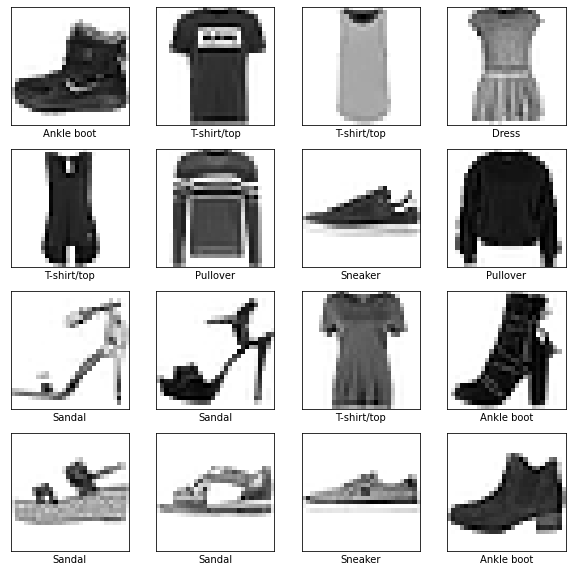

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow((255 * train_images[i]).astype(np.int).squeeze(), cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

plt.show()

### Generator
For training GANs we need to further define our generator and discriminator network. We start by defining our generator network, which should map from our noise + label space into the space of images (latent-vector size --> image size). Adding the label the input of to both the generator and discriminator should enforce the generator to produce samples from the according class.

#### Task
Design a meaningful generator model! Remember to check the latent and image dimensions.  
You can make use of the 'DCGAN guidelines'. Use a meaningful final activation function!

In [ ]:
def generator_model(latent_size):
    """ Generator network """
    latent = layers.Input(shape=(latent_size,), name="noise")

    return keras.models.Model(latent, z, name="generator")

Build and check the shapes of our generator!

In [ ]:
latent_size = 100
g = generator_model(latent_size)
g.summary()

We can further plot the model.

In [ ]:
keras.utils.plot_model(g, show_shapes=True)

### Discriminator
The task of the discriminator is to measure the similarity between the fake images (output of the generator) and the real images. So, the network maps from the image space into a 1D space where we can measure the 'distance' between the distributions of the real and generated images (image size --> scalar). Also, here we may add the class label to the discriminator.

#### Task
Design a power- and meaningful discriminator model!  

Remember that you can make use of the DCGAN guidelines (use convolutions!) and check the image dimensions (compare Sec. 18.2.3). We need a `softmax` as last activation function in the discriminator!

In [ ]:
def discriminator_model(drop_rate=0.25):
    """ Discriminator network """
    image = layers.Input(shape=(28,28,1), name="images")

    return keras.models.Model(image, x, name="discriminator")

In [ ]:
d = discriminator_model()
d.summary()
d_opt = keras.optimizers.Adam(lr=2e-4, beta_1=0.5, decay=0.0005)
d.compile(loss='binary_crossentropy', optimizer=d_opt, metrics=["acc"])

We can further plot the model.

In [ ]:
keras.utils.plot_model(d, show_shapes=True)

### Training preparations
After building the generator and discriminator, we have to compile it. But before, we have to freeze the weights of the discriminator. (Remember that we have to fix the discriminator weights for training the generator because we want to fool the discriminator by drawing excellent images, not by making our discriminator a worse classifier).

In [ ]:
def make_trainable(model, trainable):
    ''' Freezes/unfreezes the weights in the given model '''
    for layer in model.layers:
        # print(type(layer))
        if type(layer) is layers.BatchNormalization:
            layer.trainable = True
        else:
            layer.trainable = trainable

Note that after we compiled a model, calling `make_trainable` will have no effect until compiling the model again.`

In [ ]:
make_trainable(d, False)  # freeze the critic during the generator training
make_trainable(g, True)  # unfreeze the generator during the generator training

We build the pipeline for the generator training by stacking the generator on the discriminator (with frozen weights).

In [ ]:
gen_input = g.inputs
generator_training = keras.models.Model(gen_input, d(g(gen_input)))
generator_training.summary()

In [ ]:
keras.utils.plot_model(generator_training, show_shapes=True)

In [ ]:
g_opt = keras.optimizers.Adam(lr=2e-4, beta_1=0.5, decay=0.0005)
generator_training.compile(loss='binary_crossentropy', optimizer=g_opt)

We pre-train the discriminator using 5000 real and 5000 fakes samples (pure noise, since the generator wasn't updated yet).

In [ ]:
ntrain = 5000
no = np.random.choice(len(train_images), size=ntrain, replace='False')
real_train = train_images[no,:,:,:]   # sample real images from training set
noise_gen = np.random.uniform(0,1,size=[ntrain, latent_size])
generated_images = g.predict(noise_gen)  # generate fake images with untrained generator

X = np.concatenate((real_train, generated_images))
y = np.zeros([2*ntrain, 2])   # class vector: one-hot encoding
y[:ntrain, 1] = 1             # class 1 for real images
y[ntrain:, 0] = 1             # class 0 for generated images

# - Train the discriminator for 1 epoch on this dataset.
d.fit(X,y, epochs=1, batch_size=64)

####  Task
Set up the adversarial training

In [ ]:
losses = {"d":[], "g":[]}
discriminator_acc = []
batch_size = 64
nsamples = len(train_images)
iterations_per_epoch = nsamples / batch_size   # Number of training steps per epoch len(train_images)
epochs = 15

iters = 0

for epoch in range(epochs):
    print("Epoch: {0:2d}/{1:2d}".format(epoch, epochs))
    perm = np.random.choice(nsamples, size=nsamples, replace='False')

    for i in range(int(iterations_per_epoch)):
        
        # Create a mini-batch of data (X: real images + fake images, y: corresponding class vectors)
        image_batch = train_images[perm[i*batch_size:(i+1)*batch_size],:,:,:]    # real images   
        noise_gen = np.random.uniform(0.,1.,size=[batch_size, latent_size])
        
        # Generate images using the generator (set correct labels)
        generated_images = g.predict(noise_gen)

        X = np.concatenate((image_batch, generated_images))
        y = 

    
        # Train the discriminator on the mini-batch
        d_loss, d_acc  = d.train_on_batch(X,y)
        losses["d"].append(d_loss)
        discriminator_acc.append(d_acc)
    
        # Create a new mini-batch of data (X_: noise, y_: class vectors pretending that these produce real images)
        X_ = 
        y_ =
    
        # Train the generator part of the GAN on the mini-batch
        g_loss = generator_training.train_on_batch(X_, y_)
        losses["g"].append(g_loss)

        iters +=1

        if iters % 1000 == 1: 
          # Plot some fake images    
          noise = np.random.uniform(0.,1.,size=[16,latent_size])
          generated_images = g.predict(noise)
          plt.figure(figsize=(5, 5))
          
          for i in range(4):
              plt.subplot(2,2,i+1)
              plt.xticks([])
              plt.yticks([])
              plt.grid(False)
              img = plt.imshow((255 * generated_images[i]).astype(np.int).squeeze(), cmap=plt.cm.binary)
      
          plt.suptitle("Iteration %i" %iters)
          plt.savefig("./fake_fMNIST_iteration_%.6i.png" % iters)


<em>After roughly 3,000 iterations, we can recognize the basic shapes of the clothes. Above iteration 10,000, the images are of good quality.</em>

## Plot the training history
Plot the loss of the discriminator and the generator as function of iterations.

In [ ]:
plt.figure(figsize=(10,8))
plt.semilogy(losses["d"], label='discriminator loss')
plt.semilogy(losses["g"], label='generator loss')
plt.ylabel("loss")
plt.xlabel("iterations")
plt.legend()
plt.show()

Plot the accuracy of the discriminator as function of iterations

In [ ]:
plt.figure(figsize=(10,8))
plt.semilogy(discriminator_acc, label='discriminator')
plt.ylabel("accuracy")
plt.xlabel("iterations")
plt.legend()
plt.show()

| Further questions |
|:-------------| 
|Check the loss and the generated images.
Does the image quality correlate with the discriminator or the generator loss?
Is the generator able to produce all classes of the dataset?
How can you improve the performance?|